### Load Data & libraries

In [2]:
import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
import seaborn as sns
import warnings

# import LibESN
from LibESN.matrix_generator import matrixGenerator
from LibESN.esn import ESN
from LibESN.esn_fit import ridgeFit, ridgeCV
from LibESN.esn_forecast import forecast
from ModelConfidenceSet import ModelConfidenceSet


In [3]:
# Load data
data = read_csv(r"C:\Users\zhouq\OneDrive - Nanyang Technological University\FYP\Codes\FYP\Data_transform.csv", header = 0, index_col=0, parse_dates=True, dayfirst=False)

# Select 3 exogenous variables 
# M1: Industrial Production Index
# M7: Retail and Food Services Sale
# M12: Effective Federal Funds Rate 

data_new = data[['GDP', 'M1', 'M7','M12']]
data_new = data_new.dropna()

# Split the data into training and testing sets
train_size = int(len(data_new) * 0.8)

GDP_fill_data  = pd.DataFrame(data_new['GDP'])
GDP_fill_data.index = GDP_fill_data.index + pd.offsets.QuarterEnd(0)
GDP_fill_data_train, GDP_fill_data_test = GDP_fill_data[:train_size], GDP_fill_data[train_size:]
display(GDP_fill_data)

x_data = pd.DataFrame(data_new.iloc[:, 1:])
x_data.index = x_data.index + pd.offsets.QuarterEnd(0)
x_train, x_test = x_data[:train_size], x_data[train_size:]
display(x_train)
display(x_test)


,GDP
Date,
1959-06-30,0.022301
1959-09-30,0.000705
1959-12-31,0.002845
1960-03-31,0.022228
1960-06-30,-0.005405
...,...
2018-12-31,0.002229
2019-03-31,0.005960
2019-06-30,0.007898


,M1,M7,M12
Date,,,
1959-06-30,0.012391,0.005828,0.196667
1959-09-30,-0.019971,-0.002374,0.123333
1959-12-31,0.019589,-0.008020,0.076667
1960-03-31,0.002654,0.009733,-0.050000
1960-06-30,-0.007252,0.003164,-0.173333
...,...,...,...
2006-09-30,0.000686,0.001006,0.086667
2006-12-31,0.002802,0.004399,-0.003333
2007-03-31,0.002561,0.003127,0.006667


,M1,M7,M12
Date,,,
2007-12-31,0.000846,0.001275,-0.233333
2008-03-31,-0.002848,-0.001386,-0.543333
2008-06-30,-0.004975,0.003301,-0.203333
2008-09-30,-0.021459,-0.008725,-0.063333
2008-12-31,-0.010904,-0.033071,-0.550000
2009-03-31,-0.015861,-0.002361,0.006667
2009-06-30,-0.007081,0.010092,0.010000
2009-09-30,0.010157,-0.001352,-0.020000
2009-12-31,0.003319,0.007367,-0.010000


In [4]:
def normalize_train_test(train, test, return_mu_sig=False):
    m_train = train.mean()
    s_train = (train - train.mean()).std()
    if return_mu_sig:
        return (train - m_train)/s_train, (test - m_train)/s_train, m_train, s_train
    else:
        return (train - m_train)/s_train, (test - m_train)/s_train
    

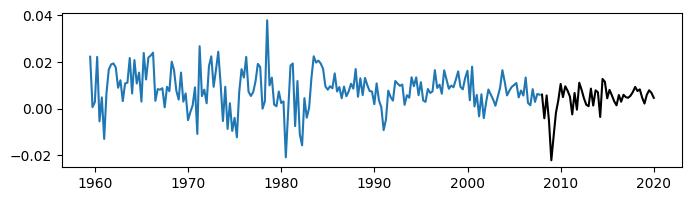

In [4]:
# plot dataset
plt.figure(figsize=(8,2))
plt.plot(GDP_fill_data_train, label = 'Train')
plt.plot(GDP_fill_data_test, label = 'Test', color = 'black')

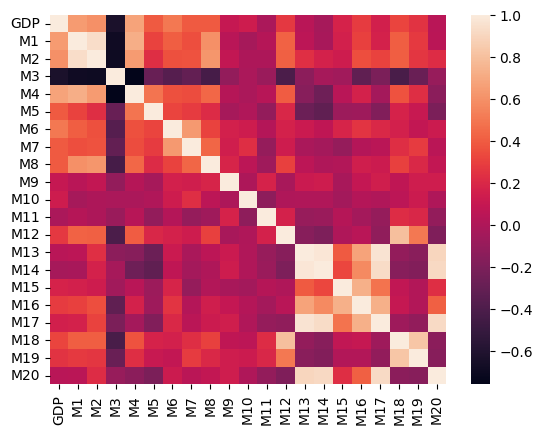

In [5]:
# check correlations between variables
corr_matrix_all = sns.heatmap(data.corr(), annot=False)

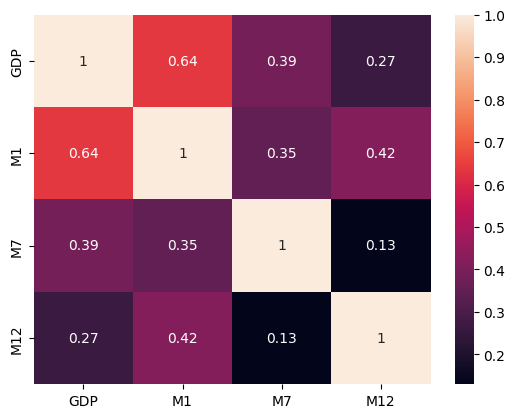

In [6]:
corr_matrix = sns.heatmap(data_new.corr(), annot=True)

### Models

#### ESN

In [5]:
# construct individual ESN
# K is size of inputs 
K = int(x_data.shape[1])
print(int(x_data.shape[1]))

# ESN with reservoir dim = 20 , sparsity = 10/20 (50%)
esn_a = ESN(
    None,
    smap=np.tanh, 
    A=matrixGenerator((20 , 20), dist='sparse_normal', normalize= 'eig', sparsity=10/20, seed=1234), 

    C=matrixGenerator((20, K), dist='sparse_uniform', normalize='norm2', sparsity=10/20, seed=1234), 

    zeta=np.zeros((20, 1)), 
    rho=0.5, 
    gamma=1, 
    leak=0,
)


3


In [6]:
# build single reservoir ESN with reservoir dim = 30, sparsity = 10/30 (33.3%)

esn_b = ESN(
    None,
    smap=np.tanh, 
    A=matrixGenerator((30, 30), dist='sparse_normal', normalize= 'eig', sparsity=10/30, seed=1234), 

    C=matrixGenerator((30, K), dist='sparse_uniform', sparsity=10/30, normalize='norm2', seed=1234), 

    zeta=np.zeros((30, 1)), 
    rho=0.5, 
    gamma=1, 
    leak=0,
)


In [7]:
# ESN with reservoir dim = 80 , sparsity = 10/80 (12.5%)
esn_c = ESN(
    None,
    smap=np.tanh, 
    A=matrixGenerator((80 , 80), dist='sparse_normal', normalize= 'eig', sparsity=10/80, seed=1234), 

    C=matrixGenerator((80, K), dist='sparse_uniform', normalize='norm2', sparsity=10/80, seed=1234), 

    zeta=np.zeros((80, 1)), 
    rho=0.5, 
    gamma=1, 
    leak=0,
)


In [8]:
# ESN with reservoir dim = 120, sparsity = 10/120 (8.3%)
esn_d = ESN(
    None,
    smap=np.tanh, 
    A=matrixGenerator((120, 120), dist='sparse_normal', sparsity=10/120, normalize= 'eig', seed=1234), 

    C=matrixGenerator((120, K), dist='sparse_uniform', sparsity=10/120, normalize='norm2', seed=1234), 

    zeta=np.zeros((120, 1)), 
    rho=0.5, 
    gamma=1, 
    leak=0,
)


In [9]:
esn_e = ESN(
    None,
    smap=np.tanh, 
    A=matrixGenerator((150, 150), dist='sparse_normal', sparsity=10/150, normalize= 'eig', seed=1234), 

    C=matrixGenerator((150, K), dist='sparse_uniform', sparsity=10/150, normalize='norm2', seed=1234), 

    zeta=np.zeros((150, 1)), 
    rho=0.5, 
    gamma=1, 
    leak=0,
)

#### ARX

In [12]:
order = (1, 0, 0)  # AR(1)
arx_model = ARIMA(endog=GDP_fill_data_train, exog=x_train, order=order)
arx_fit = arx_model.fit(method='yule_walker')

c:\Users\zhouq\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\zhouq\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\zhouq\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)


#### VAR

In [13]:
# choose an optimal lag 
data_new_train, data_new_test = data_new[:train_size], data_new[train_size:]

var_model = sm.tsa.VAR(data_new_train)
var_lag = var_model.select_order(maxlags=8)
var_lag.summary()
# lowest BIC for lag 1

c:\Users\zhouq\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BQ-DEC will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-33.15,-33.08,4.014e-15,-33.12
1,-33.57,-33.22*,2.638e-15,-33.43*
2,-33.63,-33.01,2.472e-15,-33.38
3,-33.75,-32.85,2.209e-15,-33.38
4,-33.70,-32.52,2.322e-15,-33.22
5,-33.86*,-32.40,1.982e-15*,-33.27
6,-33.85,-32.11,2.013e-15,-33.14
7,-33.77,-31.76,2.179e-15,-32.95
8,-33.74,-31.45,2.253e-15,-32.81


In [14]:
var_fit = var_model.fit(1)
var_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 19, Mar, 2024
Time:                     15:25:08
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -32.8320
Nobs:                     193.000    HQIC:                  -33.0332
Log likelihood:           2125.49    FPE:                3.93042e-15
AIC:                     -33.1701    Det(Omega_mle):     3.54820e-15
--------------------------------------------------------------------
Results for equation GDP
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.006196         0.000831            7.454           0.000
L1.GDP        -0.151064         0.080886           -1.868           0.062
L1.M1          0.823727         0.127392            6.466           0.000
L1.M7          0

In [15]:
# Check for autocorrelation
# A value near 2 indicates non-autocorrelation; a value toward 0 indicates positive autocorrelation; a value toward 4 indicates negative autocorrelation

from statsmodels.stats.stattools import durbin_watson
out_dw = durbin_watson(var_fit.resid)

for col, val in zip(data_new[:train_size].columns, out_dw):
    print((col), ':', round(val, 2))

GDP : 1.92
M1 : 1.91
M7 : 1.98
M12 : 2.16


### Model Fitting and Fixed Parameter Forecast

##### ESN

In [10]:
def esn_fit(esnModel, GDP_data, exo_data):
    GDP_train, GDP_test = GDP_data[0], GDP_data[1]
    exo_train, exo_test = exo_data[0], exo_data[1]

    #normalize data
    GDP_train, GDP_test, GDP_mu_train, GDP_sig_train = (
        normalize_train_test(GDP_train, GDP_test,
            return_mu_sig=True))
    exo_train, exo_test = normalize_train_test(exo_train, exo_test)

    #cross validation to find lambda
    cv = ridgeCV().cv(model= esnModel, train_data=(exo_train, GDP_train), steps = 1, test_size = 5 )

    #fit model
    esnSingle_fit = esnModel.fit(train_data = (exo_train, GDP_train), method= ridgeFit(cv['cvLambda']), steps =1)

    #forecast
    esnSingle_for = forecast(model = esnModel, forecast_data=exo_test, fit=esnSingle_fit)

    # Compute pointwise forecasts by undoing normalization
    esn_forecast = (esnSingle_for['forecast'])* GDP_sig_train.to_numpy() + GDP_mu_train.to_numpy()

    # plot 
    plt.figure(figsize=(8,2))
    plt.plot(data_new.index[:len(GDP_train)], GDP_train, label='Train')
    plt.plot(data_new.index[len(GDP_train):],GDP_test, label='Test')
    plt.plot(data_new.index[len(GDP_train):], esn_forecast[0:len(GDP_test)], label='Predictions')
    plt.grid()
    plt.legend(loc='upper left')
    plt.show()

    #find RMSE
    mse = mean_squared_error(GDP_data[1], esn_forecast[0:len(GDP_test)])
    mae = mean_absolute_error(GDP_data[1], esn_forecast[0:len(GDP_test)])
    rmse = math.sqrt(mse)
    
    #output
    return({'Lambda': cv['cvLambda'], 'rmse': rmse, 'MAE':mae,'forecast': esn_forecast})

                            

In [60]:
# hyperparameter tuning -- to find the best rho and gamma
def esn_fit_cv(GDP_data, exo_data):
    train_size = int(len(GDP_data)*0.8)
    GDP_train, GDP_test = GDP_data[:train_size], GDP_data[train_size:]
    exo_train, exo_test = exo_data[:train_size], exo_data[train_size:]

    #normalize data
    GDP_train, GDP_test, GDP_mu_train, GDP_sig_train = (
        normalize_train_test(GDP_train, GDP_test,
            return_mu_sig=True))
    exo_train, exo_test = normalize_train_test(exo_train, exo_test)

    lambdas_cv = np.zeros((10,10))
    rmse_cv = np.zeros((10,10))

    i_index = 0
    j_index = 0
    for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
        j_index = 0
        for j in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
            # setup ESN
            esnModel = ESN(
            None,
            smap=np.tanh, 
            A=matrixGenerator((80, 80), dist='sparse_normal', sparsity=10/80, normalize= 'eig', seed=1234), 

            C=matrixGenerator((80, K), dist='sparse_uniform', sparsity=10/80, normalize='norm2', seed=1234), 

            zeta=np.zeros((80, 1)), 
            rho=i, 
            gamma=j, 
            leak=0,
            )
            
            #cross validation to find lambda
            cv = ridgeCV().cv(model= esnModel, train_data=(exo_train, GDP_train), steps = 1, test_size = 5 )

            #fit model
            esn_fit = esnModel.fit(train_data = (exo_train, GDP_train), method= ridgeFit(cv['cvLambda']), steps =1)

            #forecast for train data
            esn_for = forecast(model = esnModel, forecast_data=exo_test, fit=esn_fit)

            # Compute pointwise forecasts by undoing normalization
            esn_forecast = (esn_for['forecast'])* GDP_sig_train.to_numpy() + GDP_mu_train.to_numpy()

            #find RMSE
            mse = mean_squared_error(GDP_test, esn_forecast[0:len(GDP_test)])
            mae = mean_absolute_error(GDP_test, esn_forecast[0:len(GDP_test)])
            rmse = math.sqrt(mse)

            lambdas_cv[i_index , j_index] = (round(cv['cvLambda'],5))
            rmse_cv[i_index , j_index] = (round(rmse,6))

            j_index = j_index + 1
        i_index = i_index+1
        

    min_index = np.unravel_index(np.argmin(rmse_cv, axis=None), rmse_cv.shape)
    min_value = rmse_cv[min_index]
    print('Min RMSE is: ', min_value)
    print('Best rho and gamma index is: ', min_index)
    return{'rmse': rmse, 'lambda':lambdas_cv}
        
 

                            

In [62]:
esn_cv = esn_fit_cv(GDP_data= GDP_fill_data_train, exo_data= x_train)

Min RMSE is:  0.56691
Best rho and gamma index is:  (4, 9)


In [66]:
print('rho is:' ,[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1][4])
print('gamma is:', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1][9])

rho is: 0.5
gamma is: 1


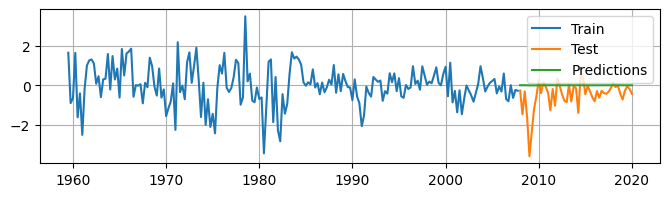

In [67]:
esn_fit_a = esn_fit(esn_a, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test])

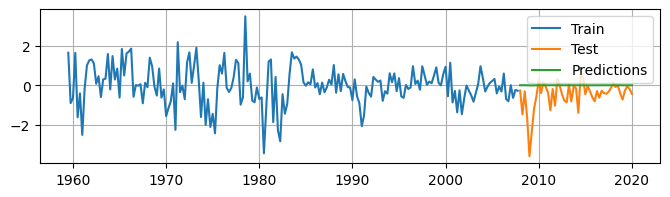

In [13]:
esn_fit_b = esn_fit(esn_b, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test])

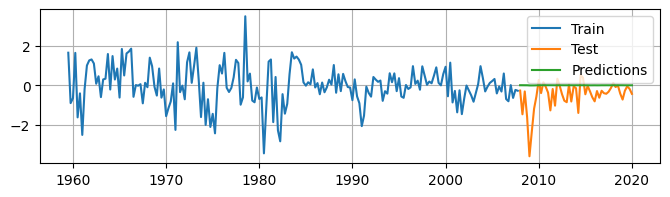

In [15]:
esn_fit_c = esn_fit(esn_c, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test])

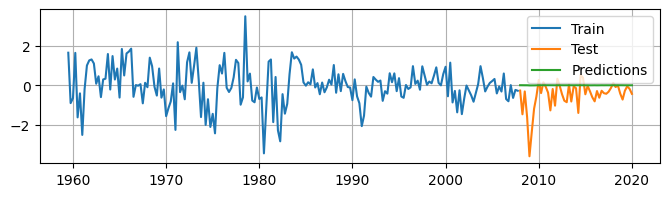

In [16]:
esn_fit_d = esn_fit(esn_d, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test])

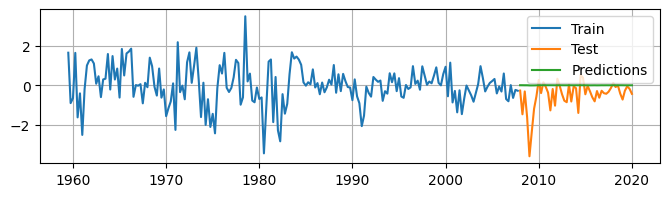

In [17]:
esn_fit_e = esn_fit(esn_e, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test])

In [20]:
rmse_a = esn_fit_a['rmse']
rmse_b = esn_fit_b['rmse']
rmse_c = esn_fit_c['rmse']
rmse_d = esn_fit_d['rmse']
rmse_e = esn_fit_e['rmse']
rmse_opt = esn_fit_a['rmse']
print("------ RMSE -------")
print(f"ESN_A \t = {round(rmse_a,6)} \t")
print(f"ESN_B \t = {round(rmse_b,6)} \t")
print(f"ESN_C \t = {round(rmse_c,6)} \t")
print(f"ESN_D \t = {round(rmse_d,6)} \t")
print(f"ESN_E \t = {round(rmse_e,6)} \t")
print(f"ESN_OPT = {round(rmse_opt,6)} \t")

------ RMSE -------
ESN_A 	 = 0.005393 	
ESN_B 	 = 0.005363 	
ESN_C 	 = 0.005172 	
ESN_D 	 = 0.005299 	
ESN_E 	 = 0.005172 	
ESN_OPT = 0.005393 	


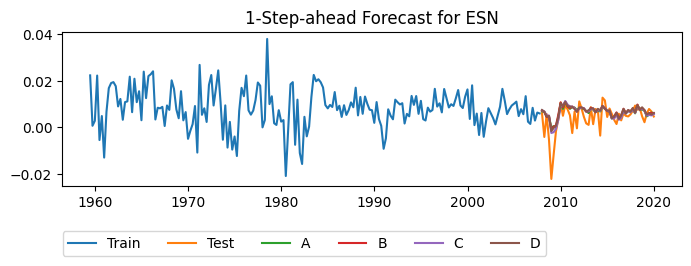

In [22]:
# Plot the actual vs. predicted values
plt.figure(figsize=(8,2))
plt.plot(data_new.index[:len(GDP_fill_data_train)], GDP_fill_data_train, label='Train')
plt.plot(data_new.index[len(GDP_fill_data_train):],GDP_fill_data_test, label='Test')
plt.plot(data_new.index[len(GDP_fill_data_train):], esn_fit_a['forecast'][0:len(GDP_fill_data_test)], label='A')
plt.plot(data_new.index[len(GDP_fill_data_train):], esn_fit_b['forecast'][0:len(GDP_fill_data_test)], label='B')
plt.plot(data_new.index[len(GDP_fill_data_train):], esn_fit_c['forecast'][0:len(GDP_fill_data_test)], label='C')
plt.plot(data_new.index[len(GDP_fill_data_train):], esn_fit_d['forecast'][0:len(GDP_fill_data_test)], label='D')
plt.legend(bbox_to_anchor=(-0.01, -0.5), loc='lower left', ncol =6)
plt.title("1-Step-ahead Forecast for ESN")
plt.show()

#### ARX

In [23]:
# make predictions - one step ahead forecast
arx_forecast = arx_fit.predict(start=len(x_train), end=len(data_new)-1, exog=x_test)

# Evaluate the model 
mse_arx = mean_squared_error(GDP_fill_data_test, arx_forecast)
print('MSE: '+str(mse_arx))

mae_arx = mean_absolute_error(GDP_fill_data_test, arx_forecast)
print('MAE: '+str(mae_arx))

rmse_arx = math.sqrt(mse_arx)
print('RMSE: '+str(rmse_arx))

MSE: 2.578817302342955e-05
MAE: 0.0036854222576466287
RMSE: 0.005078205689358156


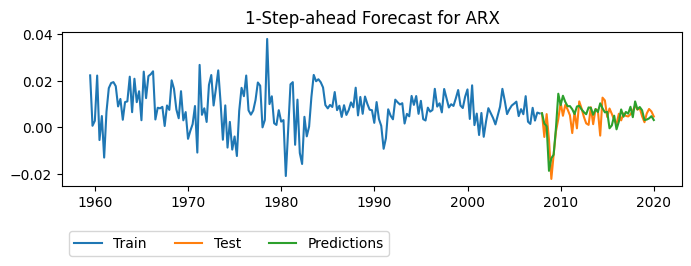

In [24]:
# Plot the actual vs. predicted values
plt.figure(figsize=(8,2))
plt.plot(data_new.index[:len(x_train)], GDP_fill_data_train, label='Train')
plt.plot(data_new.index[len(x_train):], GDP_fill_data_test, label='Test')
plt.plot(data_new.index[len(x_train):], arx_forecast, label='Predictions')
plt.title("1-Step-ahead Forecast for ARX")
plt.legend(bbox_to_anchor=(0, -0.5), loc='lower left', ncol =3)
plt.show()

#### VAR

In [25]:
lag_order = var_fit.k_ar
print(lag_order)

# one step ahead GDP forecast
var_forecast = np.zeros((len(GDP_fill_data_test),4))

for i in range(len(GDP_fill_data_test)):
    if i > 0:
        var_fore = var_fit.forecast(data_new_test.values[[i-1]], 1)
        var_forecast[i]= var_fore
    else:
        var_fore = var_fit.forecast(data_new_train.values[-lag_order:], 1)
        var_forecast[i]= var_fore


1


In [26]:
print(var_forecast[:,0])
rmse_var = np.sqrt(mean_squared_error(GDP_fill_data_test,var_forecast[:,0]))
print('RMSE: '+str(rmse_var))

[ 0.00730255  0.00644014  0.00455665  0.00214078 -0.01262675 -0.00658807
 -0.00564201  0.0029143   0.0137224   0.00901388  0.01322859  0.00995961
  0.0089727   0.00956573  0.00959034  0.00627288  0.01002546  0.00852659
  0.00792303  0.00684987  0.0071866   0.00943434  0.00819102  0.0067068
  0.00773485  0.00696642  0.01168801  0.00747946  0.00607977  0.00722162
  0.00096838  0.00238082  0.00609331  0.00153622  0.00350783  0.00857274
  0.00534333  0.00732068  0.00664377  0.00887294  0.00524632  0.01041941
  0.00764849  0.00851099  0.00773744  0.00450551  0.00466907  0.00455602
  0.00545764]
RMSE: 0.0044716688225654635


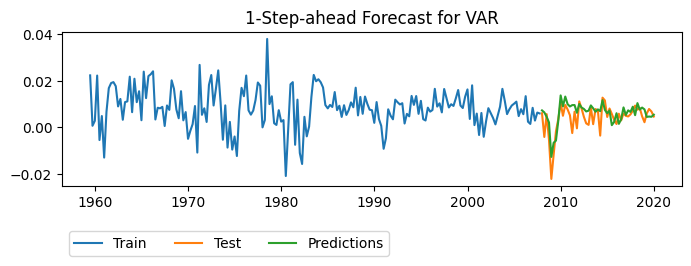

In [27]:
# Plot the actual vs. predicted values
plt.figure(figsize=(8,2))
plt.plot(data_new.index[:len(x_train)], GDP_fill_data_train, label='Train')
plt.plot(data_new.index[len(x_train):], GDP_fill_data_test, label='Test')
plt.plot(data_new.index[len(x_train):], var_forecast[:,0], label='Predictions')
plt.title("1-Step-ahead Forecast for VAR")
plt.legend(bbox_to_anchor=(0, -0.5), loc='lower left', ncol =3)
plt.show()

#### Summary of RMSE

In [28]:
rmse_a = esn_fit_a['rmse']
rmse_b = esn_fit_b['rmse']
rmse_c = esn_fit_c['rmse']
rmse_d = esn_fit_d['rmse']
rmse_e = esn_fit_e['rmse']
print("------ RMSE -------")
print(f"ESN_A \t = {round(rmse_a,6)} \t")
print(f"ESN_B \t = {round(rmse_b,6)} \t")
print(f"ESN_C \t = {round(rmse_c,6)} \t")
print(f"ESN_D \t = {round(rmse_d,6)} \t")
print(f"ESN_E \t = {round(rmse_e,6)} \t")
print(f"ARX \t = {round(rmse_arx,6)} \t")
print(f"VAR \t = {round(rmse_var,6)} \t")

------ RMSE -------
ESN_A 	 = 0.005393 	
ESN_B 	 = 0.005363 	
ESN_C 	 = 0.005172 	
ESN_D 	 = 0.005331 	
ESN_E 	 = 0.007083 	
ARX 	 = 0.005078 	
VAR 	 = 0.004472 	


### Expanding window forecast

#### ESN 

In [29]:
def esn_ew_fit(esnModel, Lambda, GDP_data, x_data, retune=False):
    GDP_fill_data_train = GDP_data[0]
    GDP_fill_data_test = GDP_data[1]

    x_train = x_data[0]
    x_test = x_data[1]

    GDP_test_dates = GDP_fill_data_test.index

    # calculate lambdas
    if retune:
        Lambdas = []
    else:
        Lambdas = Lambda

    forecast_ew = np.zeros((len(GDP_fill_data_test), 1))
    for j in tqdm(range(len(GDP_fill_data_test)), desc="EW", position=1, leave=False):
        if j > 0:
            #update data sets    
            GDP_fill_data_train_j = pd.concat([
                GDP_fill_data_train, 
                GDP_fill_data_test.iloc[0:j,]
            ])
            x_train_j = pd.concat([
                x_train, 
                x_test.iloc[0:j,]
            ])
            GDP_fill_data_test_j = GDP_fill_data_test.iloc[[j],]
            x_test_j = x_test.iloc[[j],]
        else:
            GDP_fill_data_train_j = GDP_fill_data_train
            x_train_j = x_train
            GDP_fill_data_test_j = GDP_fill_data_test.iloc[[0],]
            x_test_j = x_test.iloc[[0],]

        # Normalize
        GDP_fill_data_train_j, GDP_fill_data_test_j, mu_j, sig_j = (
            normalize_train_test(GDP_fill_data_train_j, GDP_fill_data_test_j,
                return_mu_sig=True)
        )
        x_train_j, x_test_j = (
            normalize_train_test(x_train_j, x_test_j)
        )

        if retune:
            Lambda_j = ridgeCV().cv(
                model= esnModel, 
                train_data=(x_train_j, GDP_fill_data_train_j), 
                steps = 1, 
                test_size = 5)
            
            Lambda_j = Lambda_j['cvLambda']
            Lambdas.append(Lambda_j)
            
        else:
            Lambda_j = Lambda

        #fit model
        esnSingle_fit = esnModel.fit(
            train_data = (x_train_j, GDP_fill_data_train_j), 
            method= ridgeFit(Lambda_j), 
            steps =1)

        #point forecast
        esnSingle_for = forecast(
            model = esnModel, 
            forecast_data=x_test_j, 
            fit=esnSingle_fit)

        forecast_ew[j] = (esnSingle_for['forecast'][0])* sig_j + mu_j #undo normalizing 
        #print(j)

    forecast_ew = pd.DataFrame(data=forecast_ew, index=GDP_test_dates,)
    mse_ew = mean_squared_error(GDP_fill_data_test, forecast_ew)
    rmse_ew = math.sqrt(mse_ew)
    
    return {'forecast': forecast_ew, 'rmse': rmse_ew, 'lambda': Lambdas}
   

In [30]:
# use pinv and set lambda = 0
esn_A_ew_0 = esn_ew_fit(
    esnModel=esn_a, 
    Lambda=0, 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_B_ew_0 = esn_ew_fit(
    esnModel=esn_b, 
    Lambda=0, 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_C_ew_0 = esn_ew_fit(
    esnModel=esn_c, 
    Lambda=0, 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_D_ew_0 = esn_ew_fit(
    esnModel=esn_d, 
    Lambda=0, 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_E_ew_0 = esn_ew_fit(
    esnModel=esn_e, 
    Lambda=0, 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

In [31]:
# evaluate forcast
print("--- RMSE for EW, Lambda = 0 ---")
print(f"ESN_A_EW = {esn_A_ew_0['rmse']} \t")
print(f"ESN_B_EW = {esn_B_ew_0['rmse']} \t")
print(f"ESN_C_EW = {esn_C_ew_0['rmse']} \t")
print(f"ESN_D_EW = {esn_D_ew_0['rmse']} \t")
print(f"ESN_E_EW = {esn_E_ew_0['rmse']} \t")

--- RMSE for EW, Lambda = 0 ---
ESN_A_EW = 0.0048296141112549006 	
ESN_B_EW = 0.00562174915290611 	
ESN_C_EW = 0.016075734887392525 	
ESN_D_EW = 0.05180261272575968 	
ESN_E_EW = 0.06614644830864477 	


In [32]:
# using a fixed lambda -- same as fixed parms
esn_A_ew = esn_ew_fit(
    esnModel=esn_a, 
    Lambda=esn_fit_a['Lambda'], 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_B_ew = esn_ew_fit(
    esnModel=esn_b, 
    Lambda=esn_fit_b['Lambda'], 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_C_ew = esn_ew_fit(
    esnModel=esn_c, 
    Lambda=esn_fit_c['Lambda'], 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_D_ew = esn_ew_fit(
    esnModel=esn_d, 
    Lambda=esn_fit_d['Lambda'], 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_E_ew = esn_ew_fit(
    esnModel=esn_e, 
    Lambda=esn_fit_e['Lambda'], 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

In [33]:
# evaluate forcast for fixed lambda
print("---------- RMSE --------------")
print(f"ESN_A_EW = {esn_A_ew['rmse']} \t")
print(f"ESN_B_EW = {esn_B_ew['rmse']} \t")
print(f"ESN_C_EW = {esn_C_ew['rmse']} \t")
print(f"ESN_D_EW = {esn_D_ew['rmse']} \t")
print(f"ESN_E_EW = {esn_E_ew['rmse']} \t")

---------- RMSE --------------
ESN_A_EW = 0.005255117366999156 	
ESN_B_EW = 0.005207036666778208 	
ESN_C_EW = 0.005046733355513329 	
ESN_D_EW = 0.0051666960338285816 	
ESN_E_EW = 0.006864058659315729 	


#### ARX

In [34]:
hist_exo = x_train.copy(deep=True)
hist_endo = GDP_fill_data_train.copy(deep=True)
arx_fore_ew = list()
 
#ignore value warnings
warnings.filterwarnings("ignore")

for t in range(len(x_test)):
 # model set up and fit with updated train data
 model = ARIMA(endog=hist_endo, exog=hist_exo, order=order)
 fit = model.fit(method='yule_walker')

 #point forecast
 output = fit.forecast(steps=1, exog = x_test.iloc[t,:])
 
 # update training dataset for the next prediction
 hist_exo = hist_exo._append(x_test.iloc[t,:],ignore_index=False)
 hist_endo = hist_endo._append(GDP_fill_data_test.iloc[t,], ignore_index=False)
 
 # add forecast value to list
 arx_fore_ew.append(output.tolist()[0]) 
 # obs = test.iloc[t,0] # actual
 # print('predicted=%f, actual=%f' % (output, obs))
 
warnings.resetwarnings()

# evaluate forecasts
arx_rmse_ew = math.sqrt(mean_squared_error(GDP_fill_data_test, arx_fore_ew))
print('RMSE: '+str(arx_rmse_ew))

RMSE: 0.0050828802589139134


#### VAR

In [35]:
var_fore_ew = np.zeros((len(GDP_fill_data_test)))
data_train_ew = data_new_train.copy(deep=True)
data_test_ew = data_new_test.copy(deep=True)

warnings.filterwarnings("ignore")
for i in range(len(x_test)):
    var_model = sm.tsa.VAR(data_train_ew)
    var_fit = var_model.fit(1) # VAR(1)

    #point forecast
    if i > 0:
        var_fore = var_fit.forecast(data_test_ew.values[[i-1]], 1)
        var_fore_ew[i]= var_fore[0][0]

    else: # for i = 0 case, use last value in train 
        var_fore = var_fit.forecast(data_new_train.values[-lag_order:], 1)
        var_fore_ew[i]= var_fore[0][0]
    
    # update training dataset for the next prediction
    data_train_ew = data_train_ew._append(data_test_ew.iloc[i,:],ignore_index=False)
    
warnings.resetwarnings()

# Evaluate     
var_rmse_ew = np.sqrt(mean_squared_error(GDP_fill_data_test, var_fore_ew))
print('RMSE:', var_rmse_ew)

RMSE: 0.004396264655394312


#### Summary of RMSE for EW

In [36]:
# evaluate forcast
print("--- RMSE for EW ---")
print(f"ESN_A_EW = {round(esn_A_ew['rmse'],6)} \t")
print(f"ESN_B_EW = {round(esn_B_ew['rmse'],6)} \t")
print(f"ESN_C_EW = {round(esn_C_ew['rmse'],6)} \t")
print(f"ESN_D_EW = {round(esn_D_ew['rmse'],6)} \t")
print(f"ESN_E_EW = {round(esn_E_ew['rmse'],6)} \t")
print(f"ARX_EW \t = {round(arx_rmse_ew,6)} \t")
print(f"VAR_EW \t = {round(var_rmse_ew,6)} \t")

--- RMSE for EW ---
ESN_A_EW = 0.005255 	
ESN_B_EW = 0.005207 	
ESN_C_EW = 0.005047 	
ESN_D_EW = 0.005167 	
ESN_E_EW = 0.006864 	
ARX_EW 	 = 0.005083 	
VAR_EW 	 = 0.004396 	


### Rolling Window Forecast

#### ESN

In [37]:
def esn_rw_fit(esnModel, Lambda, GDP_data, x_data, retune=False):
    GDP_fill_data_train = GDP_data[0]
    GDP_fill_data_test = GDP_data[1]

    x_train = x_data[0]
    x_test = x_data[1]

    GDP_test_dates = GDP_fill_data_test.index
    GDP_dates = GDP_fill_data_train.index.append(GDP_fill_data_test.index)

    # calculate lambdas
    if retune:
        Lambdas = []
    else:
        Lambdas = Lambda


    forecast_rw = np.zeros((len(GDP_fill_data_test), 1))
    for j in tqdm(range(len(GDP_fill_data_test)), desc="RW", position=1, leave=False):
        if j > 0:
            #update data sets    
            GDP_fill_data_train_j = pd.concat([
                GDP_fill_data_train, 
                GDP_fill_data_test.iloc[0:j,]
            ]).iloc[j:,]
            x_train_j = pd.concat([
                x_train, 
                x_test.iloc[0:j,]
            ]).iloc[j:,]
            
            GDP_fill_data_test_j = GDP_fill_data_test.iloc[[j],]
            x_test_j = x_test.iloc[[j],]

        else:
            GDP_fill_data_train_j = GDP_fill_data_train
            x_train_j = x_train
            GDP_fill_data_test_j = GDP_fill_data_test.iloc[[0],]
            x_test_j = x_test.iloc[[0],]

        # Normalize
        GDP_fill_data_train_j, GDP_fill_data_test_j, mu_j, sig_j = (
            normalize_train_test(GDP_fill_data_train_j, GDP_fill_data_test_j,
                return_mu_sig=True)
        )
        x_train_j, x_test_j = (
            normalize_train_test(x_train_j, x_test_j)
        )

        if retune:
            Lambda_j = ridgeCV().cv(
                model= esnModel, 
                train_data=(x_train_j, GDP_fill_data_train_j), 
                steps = 1, 
                test_size = 5)
            
            Lambda_j = Lambda_j['cvLambda']
            Lambdas.append(Lambda_j)
            
        else:
            Lambda_j = Lambda

        #fit model
        esnSingle_fit = esnModel.fit(
            train_data = (x_train_j, GDP_fill_data_train_j), 
            method= ridgeFit(Lambda_j), 
            steps =1)

        #point forecast
        esnSingle_for = forecast(
            model = esnModel, 
            forecast_data=x_test_j, 
            fit=esnSingle_fit)

        forecast_rw[j] = (esnSingle_for['forecast'][0])* sig_j + mu_j #undo normalizing 
        #print(j)

    forecast_rw = pd.DataFrame(data=forecast_rw, index=GDP_test_dates,)
    mse_rw = mean_squared_error(GDP_fill_data_test, forecast_rw)
    rmse_rw = math.sqrt(mse_rw)
    
    return {'forecast': forecast_rw, 'rmse': rmse_rw, 'lambda': Lambdas}
   

In [38]:
# using lamnda = 0
esn_A_rw_0 = esn_rw_fit(
    esnModel=esn_a, 
    Lambda=0, 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_B_rw_0 = esn_rw_fit(
    esnModel=esn_b, 
    Lambda=0, 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_C_rw_0 = esn_rw_fit(
    esnModel=esn_c, 
    Lambda=0, 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_D_rw_0 = esn_rw_fit(
    esnModel=esn_d, 
    Lambda=0, 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_E_rw_0 = esn_rw_fit(
    esnModel=esn_e, 
    Lambda=0, 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

In [39]:
# evaluate forcast for lambda = 0 
print("------ RMSE for RW, lambda = 0 -------")
print(f"ESN_A_RW = {esn_A_rw_0['rmse']} \t")
print(f"ESN_B_RW = {esn_B_rw_0['rmse']} \t")
print(f"ESN_C_RW = {esn_C_rw_0['rmse']} \t")
print(f"ESN_D_RW = {esn_D_rw_0['rmse']} \t")
print(f"ESN_E_RW = {esn_E_rw_0['rmse']} \t")

------ RMSE for RW, lambda = 0 -------
ESN_A_RW = 0.0052385904378496415 	
ESN_B_RW = 0.005085582704532523 	
ESN_C_RW = 0.0238313137712864 	
ESN_D_RW = 0.061254219024311544 	
ESN_E_RW = 0.08210554765047809 	


In [40]:
# using a fixed lambda
esn_A_rw = esn_rw_fit(
    esnModel=esn_a, 
    Lambda=esn_fit_a['Lambda'], 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_B_rw = esn_rw_fit(
    esnModel=esn_b, 
    Lambda=esn_fit_b['Lambda'], 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_C_rw = esn_rw_fit(
    esnModel=esn_c, 
    Lambda=esn_fit_c['Lambda'], 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_D_rw = esn_rw_fit(
    esnModel=esn_d, 
    Lambda=esn_fit_d['Lambda'], 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_E_rw = esn_rw_fit(
    esnModel=esn_e, 
    Lambda=esn_fit_e['Lambda'], 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

In [41]:
# evaluate forcast for lambda = fixed 
print("--------- RMSE for RW -----------")
print(f"ESN_A_RW = {esn_A_rw['rmse']} \t")
print(f"ESN_B_RW = {esn_B_rw['rmse']} \t")
print(f"ESN_C_RW = {esn_C_rw['rmse']} \t")
print(f"ESN_D_RW = {esn_D_rw['rmse']} \t")
print(f"ESN_E_RW = {esn_E_rw['rmse']} \t")

--------- RMSE for RW -----------
ESN_A_RW = 0.005193680443200447 	
ESN_B_RW = 0.005121893403293513 	
ESN_C_RW = 0.004978386193948225 	
ESN_D_RW = 0.005078785093546949 	
ESN_E_RW = 0.006804613995846122 	


#### ARX

In [42]:
hist_exo_rw = x_train.copy(deep=True)
hist_endo_rw = GDP_fill_data_train.copy(deep=True)
arx_fore_rw = list()

warnings.filterwarnings("ignore")

for t in range(len(x_test)):
 # model set up and fit
 model = ARIMA(endog=hist_endo_rw, exog=hist_exo_rw, order=order)
 fit = model.fit(method='yule_walker')
 output = fit.forecast(steps=1, exog = x_test.iloc[t,])
 
 # update training dataset with observed data
 hist_exo = hist_exo.iloc[1:]._append(x_test.iloc[t,:],ignore_index=False)
 hist_endo = hist_endo.iloc[1:]._append(GDP_fill_data_test.iloc[t,], ignore_index=False)
 
 arx_fore_rw.append(output.tolist()[0]) 

warnings.resetwarnings()

# evaluate forecasts
arx_rmse_rw = math.sqrt(mean_squared_error(GDP_fill_data_test, arx_fore_rw))
print('RMSE: '+str(arx_rmse_rw))

RMSE: 0.0051197002916845095


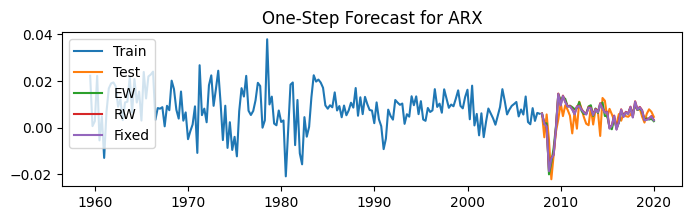

In [43]:
# plot forecasts against actual outcomes
plt.figure(figsize=(8,2))
plt.plot(data_new.index[:len(x_train)], GDP_fill_data_train, label='Train')
plt.plot(data_new.index[len(x_train):], GDP_fill_data_test, label='Test')
plt.plot(data_new.index[len(x_train):], arx_fore_ew, label='EW')
plt.plot(data_new.index[len(x_train):], arx_fore_rw, label='RW')
plt.plot(data_new.index[len(x_train):], arx_forecast, label='Fixed')
plt.title("One-Step Forecast for ARX")
plt.legend()
plt.show()

#### VAR

In [44]:
var_fore_rw = np.zeros((len(GDP_fill_data_test)))
data_train_rw = data_new_train.copy(deep=True)
data_test_rw = data_new_test.copy(deep=True)

warnings.filterwarnings("ignore")
for i in range(len(x_test)):
    var_model = sm.tsa.VAR(data_train_rw)
    var_fit = var_model.fit(1) # VAR(1)

    #point forecast
    if i > 0:
        var_fore = var_fit.forecast(data_test_rw.values[[i-1]], 1)
        var_fore_rw[i]= var_fore[0][0]

    else: # for i = 0 case, use last value in train 
        var_fore = var_fit.forecast(data_new_train.values[-lag_order:], 1)
        var_fore_rw[i]= var_fore[0][0]
    
    # update training dataset for the next prediction
    data_train_rw = data_train_rw._append(data_test_ew.iloc[i,:],ignore_index=False).iloc[1:,:]
    
warnings.resetwarnings()

# Evaluate     
var_rmse_rw = np.sqrt(mean_squared_error(GDP_fill_data_test, var_fore_rw))
print('RMSE:', var_rmse_rw)

RMSE: 0.00434138931571347


#### Summary of RMSE

In [45]:
rmse_sum_arx = {'Forecast Methods': ['Fixed Parameters', 'Expanding Window', 'Rolling Window'], 
            'RMSE': [rmse_arx, arx_rmse_ew, arx_rmse_rw ]}

print(pd.DataFrame(rmse_sum_arx).to_string(index=False))

Forecast Methods     RMSE
Fixed Parameters 0.005078
Expanding Window 0.005083
  Rolling Window 0.005120


In [46]:
rmse_sum_var = {'Forecast Methods': ['Fixed Parameters', 'Expanding Window', 'Rolling Window'], 
            'RMSE': [rmse_var, var_rmse_ew, var_rmse_rw ]}

print(pd.DataFrame(rmse_sum_var).to_string(index=False))

Forecast Methods     RMSE
Fixed Parameters 0.004472
Expanding Window 0.004396
  Rolling Window 0.004341


In [47]:
# evaluate forcast
print("--- RMSE for RW ---")
print(f"ESN_A_RW = {round(esn_A_rw['rmse'],6)} \t")
print(f"ESN_B_RW = {round(esn_B_rw['rmse'],6)} \t")
print(f"ESN_C_RW = {round(esn_C_rw['rmse'],6)} \t")
print(f"ESN_D_RW = {round(esn_D_rw['rmse'],6)} \t")
print(f"ESN_E_RW = {round(esn_E_rw['rmse'],6)} \t")
print(f"ARX_RW \t = {round(arx_rmse_rw,6)} \t")
print(f"VAR_RW \t = {round(var_rmse_rw,6)} \t")

--- RMSE for RW ---
ESN_A_RW = 0.005194 	
ESN_B_RW = 0.005122 	
ESN_C_RW = 0.004978 	
ESN_D_RW = 0.005079 	
ESN_E_RW = 0.006805 	
ARX_RW 	 = 0.00512 	
VAR_RW 	 = 0.004341 	


### Direct Mutli-step Forecast

#### ESN

In [48]:
# 8 steps ahead 
from LibESN.esn_forecast import forecastDirectMultistep
def esn_fit_multistep(esnModel, GDP_data, exo_data, n_step):
    GDP_train, GDP_test = GDP_data[0], GDP_data[1]
    exo_train, exo_test = exo_data[0], exo_data[1]

    #normalize data
    GDP_train, GDP_test, GDP_mu_train, GDP_sig_train = (
        normalize_train_test(GDP_train, GDP_test,
            return_mu_sig=True))
    exo_train, exo_test = normalize_train_test(exo_train, exo_test)

    #cross validation to find lambda
    cv = ridgeCV().cvDirectMultistep(
        model= esnModel, 
        train_data=(exo_train, GDP_train), 
        steps = n_step, 
        test_size = 5 )

    #fit model
    esn_fit_multi = esnModel.fitDirectMultistep(
        train_data = (exo_train, GDP_train), 
        method= ridgeFit(cv['cvLambda']), 
        steps =n_step)

    #forecast
    esn_for = forecastDirectMultistep(
        model = esnModel, 
        forecast_data=exo_test, 
        fit=esn_fit_multi)
    
    #undo norm
    esn_for['forecast'] = esn_for['forecast']* GDP_sig_train.to_numpy() + GDP_mu_train.to_numpy()

    # Compute pointwise forecasts
    esnSingle_fix_forecast = (esn_for['forecast'][0]* GDP_sig_train.to_numpy() + GDP_mu_train.to_numpy())

    #output
    return({'Lambda': cv['cvLambda'], 
            'Point forecast': esnSingle_fix_forecast, 
            'forecast':esn_for['forecast'],
            'fit': esn_fit_multi})

                            

In [49]:
esn_a_multistep = esn_fit_multistep(esn_a, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test], n_step = 8)

In [50]:
esn_b_multistep = esn_fit_multistep(esn_b, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test], n_step = 8)

KeyboardInterrupt: 

In [ ]:
esn_c_multistep = esn_fit_multistep(esn_c, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test], n_step = 8)

In [ ]:
esn_d_multistep = esn_fit_multistep(esn_d, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test], n_step = 8)

In [ ]:
esn_e_multistep = esn_fit_multistep(esn_e, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test], n_step = 8)

In [ ]:
def hStepRMSFE(forecasts_df):
    T = len(forecasts_df)
    steps = len(forecasts_df.columns)
    hStep_rmse = np.zeros((steps))
    for h, c in enumerate(forecasts_df.columns):
        hStep_rmse[h] = np.sqrt(np.mean(np.square(
            np.squeeze(GDP_fill_data_test.to_numpy()) - forecasts_df[[c]].to_numpy()
        )[h:(T-steps+h+1)]))
    return pd.DataFrame(data=hStep_rmse, index=range(1, 1+steps))


In [ ]:
esn_a_multi_for = np.squeeze(esn_a_multistep['forecast'])
esn_a_multi_for = pd.DataFrame(esn_a_multi_for)
# display(esn_a_multi_for)
print('RMSE for A:',hStepRMSFE(esn_a_multi_for))

esn_b_multi_for = np.squeeze(esn_b_multistep['forecast'])
esn_b_multi_for = pd.DataFrame(esn_b_multi_for)
print('RMSE for B:',hStepRMSFE(esn_b_multi_for))

esn_c_multi_for = np.squeeze(esn_c_multistep['forecast'])
esn_c_multi_for = pd.DataFrame(esn_c_multi_for)
print('RMSE for C:',hStepRMSFE(esn_c_multi_for))

esn_d_multi_for = np.squeeze(esn_d_multistep['forecast'])
esn_d_multi_for = pd.DataFrame(esn_d_multi_for)
print('RMSE for D:',hStepRMSFE(esn_d_multi_for))

esn_e_multi_for = np.squeeze(esn_e_multistep['forecast'])
esn_e_multi_for = pd.DataFrame(esn_e_multi_for)
print('RMSE for E:',hStepRMSFE(esn_e_multi_for))


RMSE for A:           0
1  0.006884
2  0.006960
3  0.007123
4  0.007268
5  0.007265
6  0.007324
7  0.007408
8  0.007379
RMSE for B:           0
1  0.006971
2  0.007000
3  0.007203
4  0.007280
5  0.007355
6  0.007364
7  0.007617
8  0.007382
RMSE for C:           0
1  0.007019
2  0.006988
3  0.007157
4  0.007268
5  0.007233
6  0.007316
7  0.007481
8  0.007381
RMSE for D:           0
1  0.007018
2  0.006995
3  0.007200
4  0.007296
5  0.007359
6  0.007337
7  0.007570
8  0.007383
RMSE for E:           0
1  0.006997
2  0.006975
3  0.007192
4  0.007300
5  0.007341
6  0.007375
7  0.007586
8  0.007402


#### ARX

In [ ]:
# use acf and pacf to predict exogeneous variables
from statsmodels.tsa.ar_model import AutoReg

In [ ]:
# make predictions - 8 steps ahead forecast
def arx_multistep(steps, data):
    GDP_data_train = data[0]['GDP']
    GDP_data_test = data[1]['GDP']
    x_train, x_test = data[0].iloc[:, 1:], data[1].iloc[:, 1:]
    GDP_test_dates = GDP_data_test.index

    #set up ARX model forecast
    model_arx = ARIMA(endog=GDP_data_train, exog=x_train, order=order)

    fit_arx = model.fit(method='yule_walker')

    forecast_multistep = np.zeros((len(GDP_test_dates), steps))

    for j in range (len(GDP_data_test)):
        if (j +steps) <= len(GDP_data_test):
            forecast_multistep[j, :] = fit.forecast(steps= steps, exog = x_test.iloc[j:j+steps,:])

        else:
            # use AR to predict the exo terms; used all available data up to time step (train_size)+j
            # M1 is AR(1)
            model_M1 = AutoReg(x_data.iloc[:train_size+j,0], lags=1)
            M1 = model_M1.fit()
            pred_M1 = M1.predict(start = len(x_train)+j, end = len(x_train) +j + steps -1)

            # M7 is AR(1)
            model_M7 = AutoReg(x_data.iloc[:train_size+j,1], lags=1)
            M7 = model_M7.fit()
            pred_M7 = M7.predict(start = len(x_train)+j, end = len(x_train)+j + steps -1)

            # M12 is AR(3)
            model_M12 = AutoReg(x_data.iloc[:train_size+j,2], lags=3)
            M12 = model_M12.fit()
            pred_M12 = M12.predict(start = len(x_train)+j, end = len(x_train)+j + steps -1)

            pred_exo = pd.concat([pred_M1, pred_M7, pred_M12], axis = 1)
            pred_exo.columns = ['M1','M7', 'M12']

            # do forecast for GDP
            forecast_multistep[j, :] = fit.forecast(steps= steps, exog = pred_exo)
        

    return pd.DataFrame(data=forecast_multistep, index=GDP_test_dates, columns=range(steps))


In [ ]:
warnings.filterwarnings("ignore")
arx_multi_fore = arx_multistep(steps =8, data=[data_new_train, data_new_test])
warnings.resetwarnings()

arx_multi_fore


,0,1,2,3,4,5,6,7
Date,,,,,,,,
2007-12-31,0.006041,0.001676,0.000496,-0.018602,-0.013195,-0.011672,-0.000224,0.014442
2008-03-31,0.001921,0.000433,-0.018586,-0.013199,-0.011671,-0.000224,0.014442,0.009537
2008-06-30,0.000678,-0.018649,-0.013183,-0.011675,-0.000223,0.014441,0.009537,0.013579
2008-09-30,-0.018404,-0.013246,-0.011659,-0.000227,0.014442,0.009537,0.013579,0.010963
2008-12-31,-0.013001,-0.011722,-0.000211,0.014438,0.009538,0.013579,0.010963,0.009078
2009-03-31,-0.011477,-0.000274,0.014454,0.009534,0.013580,0.010963,0.009078,0.009129
2009-06-30,-0.000029,0.014392,0.009550,0.013576,0.010964,0.009078,0.009129,0.007793
2009-09-30,0.014637,0.009487,0.013592,0.010960,0.009079,0.009129,0.007793,0.005713
2009-12-31,0.009732,0.013529,0.010976,0.009075,0.009130,0.007793,0.005713,0.008960


In [ ]:
hStepRMSFE(arx_multi_fore)

,0
1,0.008889
2,0.008893
3,0.008194
4,0.007367
5,0.007185
6,0.007006
7,0.006907
8,0.006863


#### VAR

In [ ]:
var_fore_multi = list()

def var_multistep(steps, data): 
    train = data[0]
    test = data[1]
    GDP_data_train = data[0]['GDP']
    GDP_data_test = data[1]['GDP']
    x_train, x_test = data[0].iloc[:, 1:], data[1].iloc[:, 1:]
    GDP_test_dates = GDP_data_test.index

    # set up model
    var_model = sm.tsa.VAR(data[0])
    var_fit = var_model.fit(1)

    # forecast multistep 
    var_forecast = np.zeros((len(test), steps))
    for i in range(len(test)):
        if i > 0:
            var_fore = var_fit.forecast(test.values[[i-1]], steps)
            var_forecast[i, :]= var_fore[:,0]
        else:
            var_fore = var_fit.forecast(train.values[-1:], steps)
            var_forecast[i, :]= var_fore[:,0]

    return pd.DataFrame(data=var_forecast, index=GDP_test_dates, columns=range(steps))

In [ ]:
var_multi_fore = var_multistep(steps =8, data=[data_new_train, data_new_test])
display(var_multi_fore)


c:\Users\zhouq\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BQ-DEC will be used.
  self._init_dates(dates, freq)


,0,1,2,3,4,5,6,7
Date,,,,,,,,
2007-12-31,0.007303,0.007958,0.008098,0.008160,0.008179,0.008186,0.008188,0.008189
2008-03-31,0.006440,0.007845,0.008058,0.008138,0.008175,0.008183,0.008187,0.008188
2008-06-30,0.004557,0.006883,0.007833,0.008033,0.008149,0.008172,0.008184,0.008187
2008-09-30,0.002141,0.007503,0.007616,0.008085,0.008132,0.008176,0.008183,0.008187
2008-12-31,-0.012627,0.004270,0.006344,0.007674,0.007992,0.008130,0.008167,0.008182
2009-03-31,-0.006588,0.002329,0.007167,0.007479,0.008059,0.008118,0.008172,0.008182
2009-06-30,-0.005642,0.004608,0.006861,0.007763,0.008041,0.008141,0.008172,0.008184
2009-09-30,0.002914,0.007059,0.007539,0.008066,0.008120,0.008173,0.008182,0.008187
2009-12-31,0.013722,0.007912,0.008786,0.008183,0.008243,0.008193,0.008194,0.008190


In [ ]:
hStepRMSFE(var_multi_fore)

,0
1,0.008001
2,0.006920
3,0.007124
4,0.007162
5,0.007196
6,0.007202
7,0.007205
8,0.007206


#### Plots for Multi-step

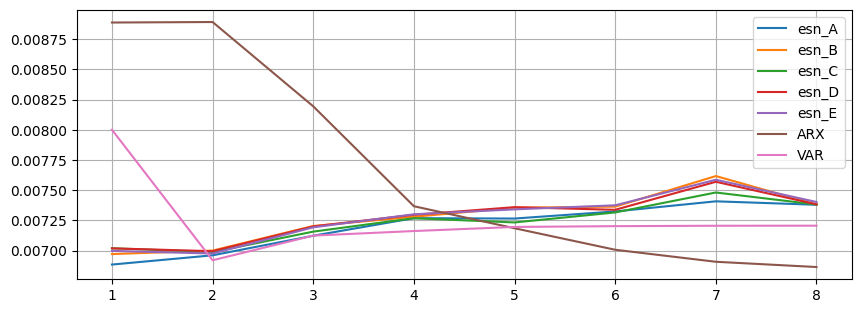

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3.5))
plt.grid()
plt.plot(hStepRMSFE(esn_a_multi_for), label="esn_A", c="C0") 
plt.plot(hStepRMSFE(esn_b_multi_for), label="esn_B", c="C1") 
plt.plot(hStepRMSFE(esn_c_multi_for), label="esn_C", c="C2") 
plt.plot(hStepRMSFE(esn_d_multi_for), label="esn_D", c="C3")
plt.plot(hStepRMSFE(esn_e_multi_for), label="esn_E", c="C4")
plt.plot(hStepRMSFE(arx_multi_fore), label="ARX", c="C5") 
plt.plot(hStepRMSFE(var_multi_fore), label="VAR", c="C6")
plt.legend()

### Comparison 
- model confidence set
- pairwise Modified Diehold-Mariano test
    - H0: 2 set of forecasts have the same accuracy
    - H1: different level of accuracy

Prepare the dataset and conduct the tests in R

In [ ]:
mcs_data_fix = pd.DataFrame(np.c_[arx_forecast.values, var_forecast[:,0], esn_fit_a['forecast'][0:49], esn_fit_b['forecast'][0:49], esn_fit_c['forecast'][0:49], esn_fit_d['forecast'][0:49], esn_fit_e['forecast'][0:49] ], columns = ['ARX', 'VAR', 'ESN_A', 'ESN_B', 'ESN_C', 'ESN_D', 'ESN_E'])

mcs_data_fix.index = data_new_test.index
mcs_data_fix.to_csv('MCS_Fix.csv', index=True)

mcs_data_fix = mcs_data_fix - GDP_fill_data_test.to_numpy()

In [ ]:
mcs_25_fix = ModelConfidenceSet(data = np.square(mcs_data_fix), alpha=0.25, B=10000, w=2, algorithm='R', seed=1234
).run()

mcs_10_fix = ModelConfidenceSet(
    data=np.square(mcs_data_fix), alpha=0.10, B=10000, w=2, algorithm='R', seed=1234
).run()

print(f"MCS 25 included: {mcs_25_fix.included}")
print(f"MCS 10 included: {mcs_10_fix.included}")

mcs_25_fix.pvalues

MCS 25 included: ['ESN_A', 'ESN_C', 'ESN_E', 'ARX', 'VAR']
MCS 10 included: ['ESN_B', 'ESN_D', 'ESN_A', 'ESN_C', 'ESN_E', 'ARX', 'VAR']


ESN_B    0.1313
ESN_D    0.1313
ESN_A    0.4935
ESN_C    0.4935
ESN_E    0.4935
ARX      0.4935
VAR      1.0000
dtype: float64

In [ ]:
mcs_data_ew = pd.DataFrame(np.c_[arx_fore_ew, var_fore_ew,esn_A_ew['forecast'], esn_B_ew['forecast'], esn_C_ew['forecast'], esn_D_ew['forecast'], esn_E_ew['forecast'] ], columns = ['ARX', 'VAR','ESN_A', ' ESN_B', 'ESN_C', 'ESN_D', 'ESN_E'])

mcs_data_ew.index = data_new_test.index
mcs_data_ew.to_csv('MCS_EW.csv', index=True)

In [ ]:
mcs_data_rw = pd.DataFrame(np.c_[arx_fore_rw, var_fore_rw, esn_A_rw['forecast'], esn_B_rw['forecast'], esn_C_rw['forecast'], esn_D_rw['forecast'], esn_E_rw['forecast'] ], columns = ['ARX','VAR', 'ESN_A', ' ESN_B', 'ESN_C', 'ESN_D', 'ESN_E'])

mcs_data_rw.index = data_new_test.index
mcs_data_rw.to_csv('MCS_RW.csv', index=True)

In [ ]:
# save all multi-step forecasts into csv files 
esn_a_multi_for.to_csv('multi_fore_ESN_A.csv', index=True)
esn_b_multi_for.to_csv('multi_fore_ESN_B.csv', index=True)
esn_c_multi_for.to_csv('multi_fore_ESN_C.csv', index=True)
esn_d_multi_for.to_csv('multi_fore_ESN_D.csv', index=True)
esn_e_multi_for.to_csv('multi_fore_ESN_E.csv', index=True)
arx_multi_fore.to_csv('multi_fore_ARX.csv', index=True)
var_multi_fore.to_csv('multi_fore_VAR.csv', index=True)
